# Probability Threshold Moving

### Intro

Many machine learning algorithms are capable of predicting a probability or scoring of class membership, and this must be interpreted before it can be mapped to a crisp class label.  This isachieved by using a threshold, such as 0.5, where all values equal or greater than the thresholdare mapped to one class and all other values are mapped to another class.

For those classification problems that have a severe class imbalance, the default thresholdcan result in poor performance.  As such, a simple and straightforward approach to improvingthe performance of a classifier that predicts probabilities on an imbalanced classification problemis to tune the threshold used to map probabilities to class labels.

In some cases, such as when using ROC Curves and Precision-Recall Curves, the best oroptimal threshold for the classifier can be calculated directly.  In other cases, it is possible touse a grid search to tune the threshold and locate the optimal value.  In this tutorial, you willdiscover how to tune the optimal threshold when converting probabilities to crisp class labelsfor imbalanced classification.


  After completing this tutorial, you will know:
 - The default threshold for interpreting probabilities to class labels is 0.5, and tuning this hyperparameter is called threshold moving.
 - How to calculate the optimal threshold for the ROC Curve and Precision-Recall Curvedirectly.
 - How to manually search threshold values for a chosen model and model evaluation metric
 
 This tutorial is divided into five parts; they are:1.  
 
1. Converting Probabilities to Class Labels
2.  Threshold-Moving for Imbalanced Classification
3.  Optimal Threshold for ROC Curve
4.  Optimal Threshold for Precision-Recall Curve
5.  Optimal Threshold Tuning

### Converting Probabilities to Class Labels

 The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the decision threshold,discrimination threshold, or simply the threshold.  The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.
 
 ...   almost  all  classifiers  generate  positive  or  negative  predictions  by  applying  a threshold  to  a  score.   The  choice  of  this  threshold  will  have  an  impact  in  thetrade-offs of positive and negative errors. *Page 53,Learning from Imbalanced Data Sets, 2018.*
 
 The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities.  This might be the case for a number of reasons, such as:
 
- The predicted probabilities are not calibrated, e.g.  those predicted by an SVM or decision tree.
- The metric used to train the model is different from the metric used to evaluate a final model.
- The class distribution is severely skewed.
- The cost of one type of misclassification is more important than another type of misclassification.

### Threshold-Moving for Imbalanced Classification

The bottom line is that when studying problems with imbalanced data, using the classifiers produced by standard machine learning algorithms without adjusting the output threshold may well be a critical mistake.*—Machine Learning from Imbalanced Data Sets 101, 2000.*

here are many reasons to choose an alternative to the default decision threshold.  For example, you may use ROC curves to analyze the predicted probabilities of a model and ROCAUC scores to compare and select a model, although you require crisp class labels from your model.  How do you choose the threshold on the ROC Curve that results in the best balance between the true positive rate and the false positive rate?

Alternately, you may use precision-recall curves to analyze the predicted probabilities of a model, precision-recall AUC to compare and select models, and require crisp class labels as predictions.  How do you choose the threshold on the Precision-Recall Curve that results in the best balance between precision and recall?  

You may use a probability-based metric to train, evaluate, and compare models like log loss (cross-entropy) but require crisp class labels to be predicted.  How do you choose the optimal threshold from predicted probabilities more generally?

Finally,  you  may  have  different  costs  associated  with  false  positive  and  false  negative misclassification, a so-called cost matrix, but wish to use and evaluate cost-insensitive models and later evaluate their predictions use a cost-sensitive measure. How do you choose a threshold that finds the best trade-off for predictions using the cost matrix?


Popular way of training a cost-sensitive classifier without a known cost matrix is to put emphasis on modifying the classification outputs when predictions are being made on new data.  This is usually done by setting a threshold on the positive class, below which the negative one is being predicted.  The value of this threshold is optimized using a validation set and thus the cost matrix can be learned from training data. *— Page 67,Learning from Imbalanced Data Sets, 2018.*


The process involves first fitting the model on a training dataset and making predictions on a test dataset.  The predictions are in the form of normalized probabilities, or scores thatare transformed into normalized probabilities.  Different threshold values are then tried and the resulting crisp labels are evaluated using a chosen evaluation metric.  The threshold that achieves the best evaluation metric is then adopted for the model when making predictions on new data in the future.  We can summarize this procedure below.

1.  Fit Model on the Training Dataset.
2.  Predict Probabilities on the Test Dataset.
3.  For each threshold in Thresholds:
        a. Convert probabilities to Class Labels using the threshold.
        b. Evaluate Class Labels.
        c. If Score is Better than Best Score.
            - Adopt Threshold.
4.  Use Adopted Threshold When Making Class Predictions on New Data.

###  Optimal Threshold for ROC Curve

A ROC curve is a diagnostic plot that evaluates a set of probability predictions made by a model on a test dataset.  A set of different thresholds are used to interpret the true positive rate and the false positive rate of the predictions on the positive (minority) class, and the scores are plotted in a line of increasing thresholds to create a curve.  The false-positive rate is plotted on the x-axis and the true positive rate is plotted on the y-axis and the plot is referred to as the Receiver Operating Characteristic curve, or ROC curve.  A diagonal line on the plot from the bottom-left to top-right indicates the curve for a no-skill classifier (predicts the majority class in all cases), and a point in the top left of the plot indicates a model with perfect skill.The curve is useful to understand the trade-off in the true-positive rate and false-positive rate for different thresholds.  The area under the ROC Curve, so-called ROC AUC, provides a single number to summarize the performance of a model in terms of its ROC Curve with a value between 0.5 (no-skill) and 1.0 (perfect skill).  

The ROC Curve is a useful diagnostic toolfor understanding the trade-off for different thresholds and the ROC AUC provides a useful number for comparing models based on their general capabilities

Thankfully, there are principled ways of locating this point.  First, let’s fit a model and calculate a ROC Curve. 

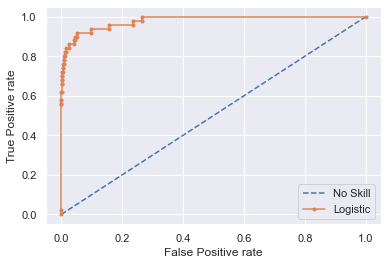

In [8]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import seaborn as sns
sns.set()

# generate dataset
X, y = make_classification(n_samples=10_000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0,
                           random_state=4)

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=2, stratify=y)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)  # predict prob
yhat = yhat[:, 1]  # pos prob only
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive rate')
pyplot.ylabel('True Positive rate')
pyplot.legend();

Running the example fits a logistic regression model on the training dataset then evaluates it using a range of thresholds on the test set, creating the ROC Curve.  We can see that there are a number of points or thresholds close to the top-left of the plot.  Which is the threshold that is optimal?

There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.  Firstly, the true positive rate is called the Sensitivity. One minus the false-positive rate is called the Specificity.  The Geometric Mean or G-mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity

Best Threshold= 0.016153, G-Mean=0.933


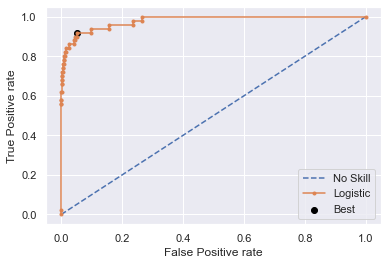

In [9]:
import numpy as np

gmeans = np.sqrt(tpr * ( 1 - fpr ))
ix_max = np.argmax(gmeans)
print('Best Threshold= %f, G-Mean=%.3f' % (thresholds[ix_max], gmeans[ix_max]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix_max], tpr[ix_max], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive rate')
pyplot.ylabel('True Positive rate')
pyplot.legend();

I turns out there is a much faster way to get the same result, called the **Youden’s J statistic**.The statistic is calculated as:


**J = Sensitivity + Specificity - 1**

As Specificity is 1 - FPR when plugged in we get: 

**J = TruePositiveRate - FalsePositiveRate** 

In [10]:
J = tpr - fpr
ix_max = np.argmax(J)
best_th = thresholds[ix_max]
print("Best threshold %f" % (best_th))

Best threshold 0.016153


### Optimal Threshold for Precision-Recall Curve

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.  Precision is the ratio of the number of true positives divided by the sum of the true positives and false positives. 

 It describes how good a model is at predicting the positive class.  Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives.  Recall is the same as sensitivity.
 
 The `precisionrecallcurve()` function can be used to calculate the curve, returning the precisionand recall scores for each threshold as well as the thresholds used

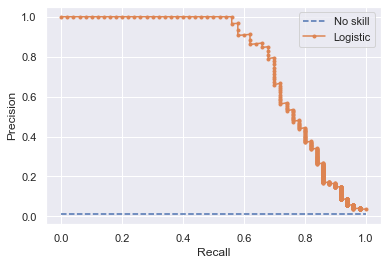

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, yhat)

no_skill = len(y_test[y_test == 1]) / len(y_test)
pyplot.plot([0,1], [no_skill, no_skill], linestyle='--', label='No skill')
pyplot.plot(recall, precision, marker='.', label= 'Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend();

Running the example calculates the precision and recall for each threshold and creates aprecision-recall plot showing that the model has some skill across a range of thresholds on this dataset.

If we are interested in a threshold that results in the best balance of precision and recall,then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures (broadcasting for all pre/rec pairs in the arrays) 

Best threshold for optimising precision and recall-> 0.256036 and best f-score-> 0.756


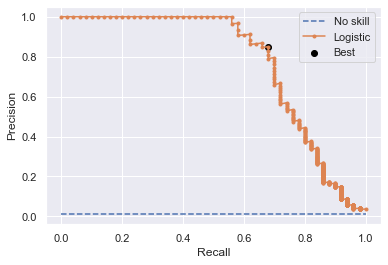

In [21]:
fscore = (2 * precision * recall) / (precision + recall)
ix_max = np.argmax(fscore)
ix_max
print("Best threshold for optimising precision and recall-> %f and best f-score-> %.3f" % (thresholds[ix_max], fscore[ix_max]))
pyplot.plot([0,1], [no_skill, no_skill], linestyle='--', label='No skill')
pyplot.plot(recall, precision, marker='.', label= 'Logistic')
pyplot.scatter(recall[ix_max], precision[ix_max], marker='o', color='black', label='Best')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend();

###  Probability Calibration

Many machine learning models are capable of predicting a probability or probability-like scores for class membership.  Probabilities provide a required level of granularity for evaluating and comparing  models,  especially  on  imbalanced  classification  problems  where  tools  like  ROC Curves are used to interpret predictions and the ROC AUC metric is used to compare model performance, both of which use probabilities.

 It is often a good idea to calibrate the predicted probabilities for nonlinear machine learning models prior to evaluating their performance.  Further, it is good practice to calibrate probabilities in general when working with imbalanced datasets, even of models like logistic regression that predict well-calibrated probabilities when the class labels are balanced.  
 
 

#### Problem of uncalibrated Probabilities 

Many machine learning algorithms can predict a probability or a probability-like score that indicates class membership.  For example, logistic regression can predict the probability of class membership directly and support vector machines can predict a score that is not a probability but could be interpreted as a probability.

The  probability  can  be  used  as  a  measure  of  uncertainty  on  those  problems  where  a probabilistic prediction is required.  This is particularly the case in imbalanced classification,where crisp class labels are often insufficient both in terms of evaluating and selecting a model.The predicted probability provides the basis for more granular model evaluation and selection,such as through the use of ROC and Precision-Recall diagnostic plots, metrics like ROC AUC,and techniques like threshold moving.

As such, using machine learning models that predict probabilities is generally preferred when working on imbalanced classification tasks.  The problem is that few machine learning models have calibrated probabilities.


Calibrated probabilities means that the probability reflects the likelihood of true events.  This might be confusing if you consider that in classification, we have class labels that are correct or not instead of probabilities.  To clarify, recall that in binary classification, we are predicting a negative or positive case as class 0 or 1.  If 100 examples are predicted with a probability of 0.8, then 80 percent of the examples will have class 1 and 20 percent will have class 0, if the probabilities are calibrated.  Here, calibration is the concordance of predicted probabilities with the occurrence of positive cases.  Uncalibrated probabilities suggest that there is a bias in the probability scores, meaning the probabilities are overconfident or under-confident in some cases.

Few machine learning algorithms produce calibrated probabilities.  This is because for amodel to predict calibrated probabilities, it must explicitly be trained under a probabilistic framework, such as **maximum likelihood estimation**.  Some examples of algorithms that provide calibrated probabilities include:

- Logistic Regression.
- Linear Discriminant Analysis.
- Naive Bayes.
- Artificial Neural Networks

Many algorithms either predict a probability-like score or a class label and must be coerced in  order  to  produce  a  probability-like  score.   As  such,  these  algorithms  often  require  their probabilities to be calibrated prior to use. 

- SVM
- Decision Trees
- Ensembles of Decision Trees(bagging, random forest, gradient boosting)
- k-Nearest Neighbors

...  class probability estimates attained via supervised learning in imbalanced scenariossystematically underestimate the probabilities for minority class instances, despiteostensibly good overall calibration. —*Class Probability Estimates are Unreliable for Imbalanced Data (and How to Fix Them), 2012.*

####  How to Calibrate Probabilities

Probabilities are calibrated by rescaling their values so they better match the distribution observed in the training data.

 we desire that the estimated class probabilities are reflective of the true underlying probability of the sample.  That is, the predicted class probability (or probability-like value) needs to be well-calibrated.  To be well-calibrated, the probabilities musteffectively reflect the true likelihood of the event of interest. *— Page 249,Applied Predictive Modeling, 2013*
 
 Probability predictions are made on training data and the distribution of probabilities is compared to the expected probabilities and adjusted to provide a better match.  This often involves splitting a training dataset and using one portion to train the model and another portion as a validation set to scale the probabilities. 
 
There are two main techniques for scaling predicted probabilities; they are Platt scaling and Isotonic regression.

- Platt Scaling.  Logistic regression model to transform probabilities.
- Isotonic Regression.  Weighted least-squares regression model to transform probabilities.

Platt scaling is a simpler method and was developed to scale the output from a support vector machine to probability values.  It involves learning a logistic regression model to perform the transform of scores to calibrated probabilities.  Isotonic regression is a more complex weighted least squares regression model.  It requires more training data, although it is also more powerful and more general.  Here, isotonic simply refers to monotonically increasing mapping of the original probabilities to the rescaled values

####  SVM With Calibrated Probabilities

We can try using the `CalibratedClassifierCV` class to wrap the SVM model and predict calibrated probabilities.  We are using stratified 10-fold cross-validation to evaluate themodel; that means 9,000 examples are used for train and 1,000 for test on each fold.  With `CalibratedClassifierCV` and 3-folds, the 9,000 examples of one fold will be split into 6,000for training the model and 3,000 for calibrating the probabilities.  This does not leave many examples of the minority class, e.g.  90/10 in 10-fold cross-validation, then 60/30 for calibration.When using calibration, it is important to work through these numbers based on your chosen model  evaluation  scheme  and  either  adjust  the  number  of  folds  to  ensure  the  datasets  are sufficiently large or even switch to a simpler train/test split instead of cross-validation if needed.Experimentation might be required.  We will define the SVM model as before,  then define the CalibratedClassifierCV with isotonic regression, then evaluate the calibrated model via repeated stratified k-fold cross-validation.

Because SVM probabilities are not calibrated by default, we would expect that calibrating them would result in an improvement to the ROC AUC that explicitly evaluates a model based on their probabilities.

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

X, y = make_classification(n_samples=10_000, n_features=2, n_redundant=0,
                          n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

model_no = SVC(gamma='scale')
model_bal = SVC(gamma='scale', class_weight='balanced')

models = [ model_no, model_bal]
# wrap the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model

# review performance

for model in models:
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print("Mean ROC AUC -> for %s is %.3f" % (model, np.mean(scores)))
    
# now apply the same steps but wrap model in calibrated probabilities

for model in models:
    calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
    scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print("Mean ROC AUC with calibrated model is  -> for %s is %.3f" % (model, np.mean(scores)))


Mean ROC AUC -> for SVC() is 0.808
Mean ROC AUC -> for SVC(class_weight='balanced') is 0.967
Mean ROC AUC with calibrated model is  -> for SVC() is 0.867
Mean ROC AUC with calibrated model is  -> for SVC(class_weight='balanced') is 0.964


Running the example evaluates the class-weighted SVM with calibrated probabilities on the imbalanced classification dataset.

In this case running the balanced cross validations only resulted in the major lift gain. 

## Other examples not tested

- Decision  Tree With Calibrated Probabilities (similar to above but DT model used)
- Grid Search probability Calibration with KNN (used grid search different Calibrated folds sizes and 2 different methods)